In [54]:
%pip install torch torchvision

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import os
import pandas as pd
import numpy as np
import hashlib
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

In [56]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 25 * 25, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 25 * 25) # change based on image dimensions?
        x = self.classifier(x)
        return x   

In [57]:
def make_pokedex(path="pokedex/pokemon.csv"):
    pokedex = pd.read_csv(path)
    return pokedex

In [58]:
def pokemon_name_to_number(name):
    pokedex = make_pokedex()
    return pokedex.index[pokedex['Name'] == name].tolist()[0]

In [59]:
def pokemon_number_to_name(number):
    pokedex = make_pokedex()
    return pokedex.iloc[number]['Name']

In [60]:
sprites_number_name = []
for i_pokemon, pokemon in enumerate(os.listdir('samples')):
    for i_img, img in enumerate(os.listdir(os.path.join('samples', pokemon))):
        fp = os.path.join('samples', pokemon, img)
        sprite_image = cv2.imread(fp)
        resized_sprite_image = np.array(cv2.resize(sprite_image, (50, 50)))
        pokemon_number = pokemon_name_to_number(pokemon)
        sprites_number_name.append([resized_sprite_image, pokemon_number, pokemon])
        
# sprites_number_name = np.array(sprites_number_name)
data = pd.DataFrame(sprites_number_name, columns = ['image', 'number', 'name'])

## Check for duplicate images

In [61]:
def hash_image(image):
    # Convert the image array to bytes and then create an MD5 hash
    return hashlib.md5(image.tobytes()).hexdigest()

# Create a dictionary to store hashes and corresponding indices
hash_dict = {}

# Iterate through each image in the array
for i, image in enumerate(data['image']):
    # Get the hash of the current image
    image_hash = hash_image(image)

    # Check if the hash already exists in the dictionary
    if image_hash in hash_dict:
        hash_dict[image_hash].append(i)
    else:
        # If the hash is not in the dictionary, add it with the current index
        hash_dict[image_hash] = [i]

In [62]:
# Locate duplicate entries in the dataframe
duplicate_loc = [hash_dict[hash][1] for hash in hash_dict if len(hash_dict[hash]) > 1]

# Drop duplicate entries
data.drop(duplicate_loc, axis=0, inplace=True)

#

(50, 50, 3)


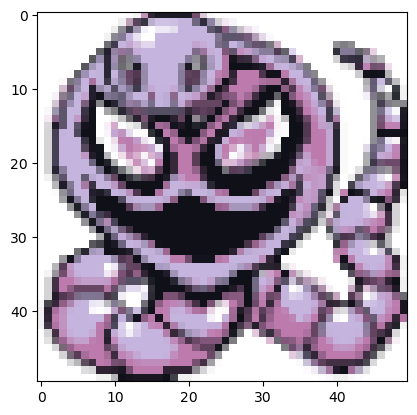

In [63]:
img1 = data.iloc[0]['image']
print(img1.shape)
plt.imshow(img1)
plt.show()

In [64]:
X = data['image']
y = data['number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

tensor_X_train = torch.stack([torch.tensor(img, dtype=torch.float32) for img in data_train['image'].values])
tensor_X_train = torch.transpose(tensor_X_train, 1, 2)
tensor_X_train = torch.transpose(tensor_X_train, 1, 3)
tensor_y_train = torch.tensor(data_train['number'].values)
tensor_train = TensorDataset(tensor_X_train, tensor_y_train)

tensor_X_test = torch.stack([torch.tensor(img, dtype=torch.float32) for img in data_test['image'].values])
tensor_X_test = torch.transpose(tensor_X_test, 1, 2)
tensor_X_test = torch.transpose(tensor_X_test, 1, 3)
tensor_y_test = torch.tensor(data_test['number'].values)
tensor_test = TensorDataset(tensor_X_test, tensor_y_test)


train_loader = DataLoader(tensor_train, batch_size=16, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=16, shuffle=True)

In [65]:
cnn = CNN(num_classes=50)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-4, momentum=0.9)

In [66]:
for epoch in range(15):
    running_loss = []
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        pred = cnn(inputs)
        loss = criterion(pred, labels)
        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()
                
    print("Epoch {} loss: {}".format(epoch + 1, np.mean(running_loss)))

print("Done!")   

100%|██████████| 136/136 [00:31<00:00,  4.34it/s]


Epoch 1 loss: 6.682770767632653


100%|██████████| 136/136 [00:29<00:00,  4.54it/s]


Epoch 2 loss: 2.8750860287862667


100%|██████████| 136/136 [00:30<00:00,  4.50it/s]


Epoch 3 loss: 1.8602439379867386


100%|██████████| 136/136 [00:30<00:00,  4.48it/s]


Epoch 4 loss: 1.0986347689348108


100%|██████████| 136/136 [00:30<00:00,  4.46it/s]


Epoch 5 loss: 0.678133769727805


100%|██████████| 136/136 [00:31<00:00,  4.25it/s]


Epoch 6 loss: 0.37986173250657673


100%|██████████| 136/136 [00:35<00:00,  3.85it/s]


Epoch 7 loss: 0.19574234365513


100%|██████████| 136/136 [00:35<00:00,  3.82it/s]


Epoch 8 loss: 0.11939206968664247


100%|██████████| 136/136 [00:35<00:00,  3.83it/s]


Epoch 9 loss: 0.09633990354247063


100%|██████████| 136/136 [00:35<00:00,  3.82it/s]


Epoch 10 loss: 0.12895749233532972


100%|██████████| 136/136 [00:35<00:00,  3.82it/s]


Epoch 11 loss: 0.05059561837611802


100%|██████████| 136/136 [00:35<00:00,  3.81it/s]


Epoch 12 loss: 0.024291176280445036


100%|██████████| 136/136 [00:35<00:00,  3.81it/s]


Epoch 13 loss: 0.010819638935251586


100%|██████████| 136/136 [00:36<00:00,  3.75it/s]


Epoch 14 loss: 0.006393743186730289


100%|██████████| 136/136 [00:36<00:00,  3.73it/s]

Epoch 15 loss: 0.004747806825488463
Done!


In [68]:
correct = 0
total = 0
cnn.eval()
eval_running_loss = []
with torch.no_grad():
    for batch, label in test_loader:
        pred = cnn(batch)
        eval_loss = criterion(pred, label)
        eval_running_loss.append(eval_loss.item())
        correct += (torch.argmax(pred,dim=1)==label).sum().item()
acc = correct/len(test_loader.dataset)
print(f"Test Acccuracy: {acc}")

Test Acccuracy: 0.7233584499461787
